## Not using Spotify Dataset
I am not using spotify dataset as it is a one class dataset (no rating values).
This does not work with my current evaluation approach using regret and normalized discounted cumulative gain.

Spotify Million Song Dataset
users => Playlist
Items => Tracks (songname + 'by' + artistname)
Time => Order in the playlist
There is no rating in Spotify, only list of songs in playlist. 
Hence, it is a one-class problem. 
I decided NOT to use Spotify's Million Song Dataset (although I thought I could in the Proposal)
as I can only evaluate on the rated movies, and since spotify's dataset is one class.
I cannot rate on one class to get a 'regret' or 'ndcg' score. 
Working with one class is another huge challenge on its own and I won't want to tackle that for RecSys this year.

## BottleNeck for Evaluating results
I completed every code that I said I would do in the project proposal except code for PMF.

However, I did not have time to run results for all 6k users as that would have taken
an entire week according to my calculations below.

The bottleneck is mainly in the training algorithm for variational bayes. 
It takes few seconds for each training iteration. 
Whereas, everything else (such as sampling from posterior), executes quickly (not noticeable to a person).

Yee Whye's variational bayes algorithm is an iterative algorithm (doesn't make use of GPU). 

As I am training after each active choice, training over all 6k users, for all 10 partitions, 
I also only tested training on all training data for current partition instead of only the selected one.
would require 6k users * 10partitions/user * 5Epochs/trainingIteration = 300k epochs. 
Each epoch takes about 5 seconds to run on movie lens.
This means the total time would be 1500000/3600 = 416 hours for the movielens-1m dataset. 

This is infeasible. Clearly, a much better model such as conjugate prior (for paper) is needed for evaluation. 

Therefore, I just ran on a few users and a few epochs for proof of concept for this report. 

Also, I only ran the entire results on MovieLens-1m although I have already written code for 100k and 20m.

# Story Plot
The breakdown of the notebook below:

## Chapter 0: Introduction and Summary of Progress related to research
My short paper deadline is April 30th (for abstract) and May 7th (for actual paper).
However, there has been changes to the paper (focus on Bayesian LREC + Conjugate Prior for quick updates
instead of evaluation).
Unfortunately, I will be graded based on what was agreed on for Project Proposal. 
Therefore, for April 15th project deadline, I am focusing this project on what was agreed based on Project Proposal
to score an A+ for Project, and will only focus on latest changes on paper for April 30th deadline. 
In short, the focus of this report will be based on the project proposal 
(ignoring anything that was listed as Future Work)
instead of the actual paper submission for April 30th.
e.g. I will work on PMF + Variational Bayes instead of Bayesian LREC (listed as Future work in project proposal). 

## Chapter 1: Parsing datasets
- Load the data using my own parser, for movielens (100k, 1m, 20m)
- Split data into train and test
- Note: I refactored nicely to all share the same abstractBaseClass 

## Chapter 2: Training Models
- Train all of it on Yee Whye Method.
- Train all of it on PMF. (Future Work)

## Chapter 3: Posterior Estimation
- Moment Matching
- Histogram Density Estimation

## Chapter 4: Acquisition Function
- Greedy (only exploitation)
- Random (only exploration)
- Epsilon Greedy
- Thompson Sampling
- Upper Confidence Bound
- Probability of Improvement
- Expected Improvement

## Chapter 5: Partitioning For Evaluation
My unique evaluation method for partition the testset into a number of partitions. 
This way the training set loops through each partition while training.

## Chapter 6: Evaluation Acquisition Function
- Train on all data from current set
- Evaluate on the average regret over all users
- Train on only selected data from current set (Future work, code is trivial, no time for evaluation)

## Chapter 7: Evaluation Model Adaptability
- Train on RMSE based on trained data
- Evaluate over the average cumulative RMSE over all users

In [1]:
# All import statements
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy

# Own libraries
from movieLensParser  import MovieLensParser100k
from movieLensParser import MovieLensParser1m
from movieLensParser import MovieLensParser20m
from evaluator import predictRMSE
from variationalBayes import trainVariationalBayes
from posteriorEstimation import HistogramSamplingPosteriorEstimation
from posteriorEstimation import MomentMatchingPosteriorEstimation
from acquisitionFunction import AcquisitionFunction

# Data directories
installDir = "/root/Github/RecommendationSystems/sclrecommender/data/"

## Movielens
dataDirectory100k = installDir + "movielens/ml-100k"
dataDirectory1m = installDir + "movielens/ml-1m"
dataDirectory20m = installDir + "movielens/ml-20m"
# All global initialization
seedNum = 196
np.random.seed(seedNum)
random.seed(seedNum)
trainTestSplit = 0.8 # 80 percent training, 20 percent test

# Chapter 1: Parsing Datasets

In [2]:
# MovieLens 100k
mlp100k = MovieLensParser100k(dataDirectory100k)
ratingMatrix = mlp100k.getRatingMatrixCopy()
# dMovie = mlp100k.parseDictionaryOfMoviesToRatingAndTime()
# userDictTrain contains all user with the first 80 percent of their rating data sorted by time
# userDictTest contains all user with the remaining 20 percent of their rating data sorted by time
userDictTrain, userDictTest = mlp100k.getTrainTestUserTime(trainTestSplit)
dMovie = mlp100k.parseDictionaryOfMoviesToRatingAndTime()
print("Number of items: ", len(dMovie))

print("Number of users: ", len(userDictTrain))
numObsvTrain = 0
numObsvTest = 0

for currUser in userDictTrain:
    numObsvTrain += len(userDictTrain[currUser])
for currUser in userDictTest:
    numObsvTest += len(userDictTest[currUser])

print("Number of observed train", numObsvTrain)
print("Number of observed test", numObsvTest)
print("Done")

Number of unique items:  1682
Number of items:  1682
Number of users:  943
Number of observed train 80000
Number of observed test 20000
Done


In [3]:
'''
mlp20m = MovieLensParser20m(dataDirectory20m)
ratingMatrix = mlp20m.getRatingMatrixCopy()
dMovie = mlp20m.parseDictionaryOfMoviesToRatingAndTime()
trainTestSplit = 0.8 # 80 percent training, 20 percent test
userDictTrain, userDictTest = mlp20m.getTrainTestUserTime(trainTestSplit)
numItem = len(dMovie) # 20m
for key in dMovie:
    print(key, len(dMovie[key]))
    break
print("Number of items: ", len(dMovie))

print("Number of users: ", len(userDictTrain))
numObsvTrain = 0
numObsvTest = 0

for currUser in userDictTrain:
    numObsvTrain += len(userDictTrain[currUser])
for currUser in userDictTest:
    numObsvTest += len(userDictTest[currUser])

print("Number of observed train", numObsvTrain)
print("Number of observed test", numObsvTest)
print("Done")
'''

'\nmlp20m = MovieLensParser20m(dataDirectory20m)\nratingMatrix = mlp20m.getRatingMatrixCopy()\ndMovie = mlp20m.parseDictionaryOfMoviesToRatingAndTime()\ntrainTestSplit = 0.8 # 80 percent training, 20 percent test\nuserDictTrain, userDictTest = mlp20m.getTrainTestUserTime(trainTestSplit)\nnumItem = len(dMovie) # 20m\nfor key in dMovie:\n    print(key, len(dMovie[key]))\n    break\nprint("Number of items: ", len(dMovie))\n\nprint("Number of users: ", len(userDictTrain))\nnumObsvTrain = 0\nnumObsvTest = 0\n\nfor currUser in userDictTrain:\n    numObsvTrain += len(userDictTrain[currUser])\nfor currUser in userDictTest:\n    numObsvTest += len(userDictTest[currUser])\n\nprint("Number of observed train", numObsvTrain)\nprint("Number of observed test", numObsvTest)\nprint("Done")\n'

In [4]:
mlp1m = MovieLensParser1m(dataDirectory1m)
ratingMatrix = mlp1m.getRatingMatrixCopy()
dMovie = mlp1m.parseDictionaryOfMoviesToRatingAndTime()
trainTestSplit = 0.8 # 80 percent training, 20 percent test
# Note: For ensuring code is right, split randomly instead of by time
# Since most benchmark splits randomly instead of by time anyway.
# RMSE is indeed much higher if I split by time,
# since it's more difficult to predict future than past
userDictTrain, userDictTest = mlp1m.getTrainTestUserRandomly(trainTestSplit)
numItem = len(dMovie) # 1m
for key in dMovie:
    print(key, len(dMovie[key]))
    break
print("Number of items: ", len(dMovie))
print("Number of users: ", len(userDictTrain))
numObsvTrain = 0
numObsvTest = 0

for currUser in userDictTrain:
    numObsvTrain += len(userDictTrain[currUser])
for currUser in userDictTest:
    numObsvTest += len(userDictTest[currUser])

print("Number of observed train", numObsvTrain)
print("Number of observed test", numObsvTest)
print("Done")

Number of unique items:  3706
0 2223
Number of items:  3706
Number of users:  6040
Number of observed train 800193
Number of observed test 200016
Done


# Chapter 2: Training Models

In [5]:
numEpoch = 4 # Training converges quickly
numHiddenDim = 10
userLatents, itemLatents, userVariances, itemVariances, varianceObsvNoise, userCovariances, itemCovariances, trainRMSE, testRMSE = trainVariationalBayes(userDictTrain, userDictTest, numItem, numEpoch, numHiddenDim)
print("Done Training")

resultFolder = "Result/"
dataName = "ml1m"
saveFileName = resultFolder + dataName + "_numDim_"  + str(numHiddenDim) + "_numEpoch_" + str(numEpoch)

# Save the latents into numpy matrices
np.save(saveFileName + "_userLatents.npy", userLatents)
np.save(saveFileName + "_itemLatents.npy", itemLatents)
np.save(saveFileName + "_userVariances.npy", userVariances)
np.save(saveFileName + "_itemVariances.npy", itemVariances)
np.save(saveFileName + "_varianceObsvNoise.npy", np.array(varianceObsvNoise))
np.save(saveFileName + "_userCovariances.npy", userCovariances)
np.save(saveFileName + "_itemCovariances.npy", itemCovariances)
print("Done Saving")

Done Training
Done Saving


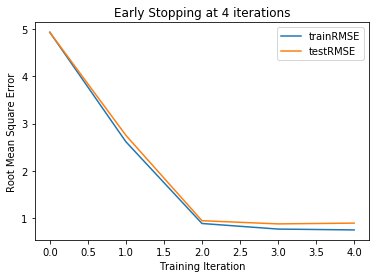

TrainRMSE:  [4.928088903064595, 2.6183134439408335, 0.8938037565675131, 0.7760419802121176, 0.7583140667511137]
TestRMSE:  [4.927116806108371, 2.7532252608488914, 0.9524908835798844, 0.8854060747100772, 0.9020081204625023]


In [6]:
x = np.array([i for i in range(len(trainRMSE))])
plt.title("Early Stopping at 4 iterations")
plt.xlabel("Training Iteration")
plt.ylabel("Root Mean Square Error")
plt.plot(x, trainRMSE, label="trainRMSE")
plt.plot(x, testRMSE, label="testRMSE")
plt.legend()
plt.show()
# Plot the figures
print("TrainRMSE: ", trainRMSE)
print("TestRMSE: ", testRMSE)

# Chapter 3: Posterior Estimation


## Chapter 3.1: MomentMatching

Number of users vs latentDim:  (6040, 10)
Number of items vs latentDim:  (3706, 10)
UserVariances.shape (10, 10)
itemVariances.shape (10, 10)
Plot a few observed items
Train Supervised Observed Rating:  4.0


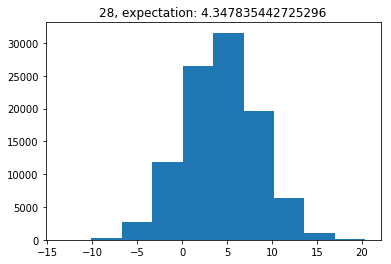

Train Supervised Observed Rating:  4.0


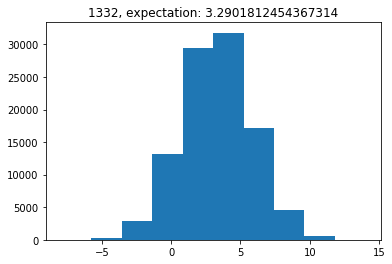

Train Supervised Observed Rating:  4.0


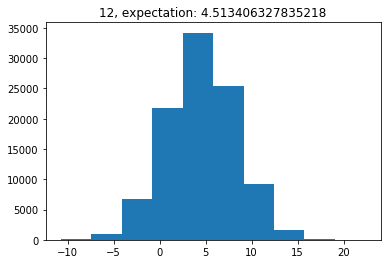

Plot a few test items
It actually generalizes quite well to test items due to early stopping
Test Supervised Observed Rating:  4.0


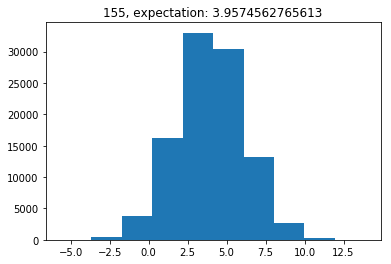

Test Supervised Observed Rating:  5.0


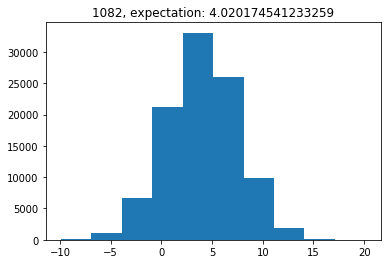

Test Supervised Observed Rating:  3.0


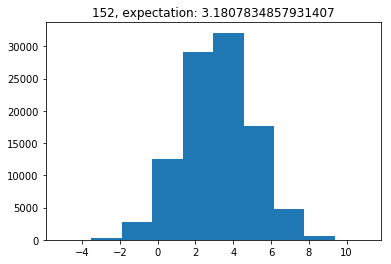

In [7]:
mmpe = MomentMatchingPosteriorEstimation(userLatents, itemLatents, userVariances, itemVariances)
numSamples = 100000
plotcount = 0

print("Number of users vs latentDim: ", userLatents.shape)
print("Number of items vs latentDim: ", itemLatents.shape)
print("UserVariances.shape", userVariances.shape)
print("itemVariances.shape", itemVariances.shape)

expectedValuesForUser = dict()
stdDevValuesForUser = dict()
sampledItemsForUser = dict()

#--------------------------------------------------
# Train on a single user for current demo
#--------------------------------------------------
numToPlot = 3 
# Pick a single user for demo
userIndex = 0
# for userIndex in range(numUsers): # Loop through over all users
if True: # Only run on one user # 
    # All the expected values for all items for current user (used for acquisition)
    expectedValuesForUser[userIndex] = np.zeros(itemLatents.shape[0])
    stdDevValuesForUser[userIndex] = np.zeros(itemLatents.shape[0])
    sampledItemsForUser[userIndex] = dict()
    # Train over all items
    for currRating in userDictTrain[userIndex]:
        itemIndex = currRating.movieId
        sampledItemsForUser[userIndex][itemIndex] = mmpe.sampleForUserAndItem(userIndex, itemIndex, numSamples)
        # Calculate the expected value for acquisition Function
        expectedValuesForUser[userIndex][itemIndex] = mmpe.expectation(sampledItemsForUser[userIndex][itemIndex])
        stdDevValuesForUser[userIndex][itemIndex] = mmpe.stddev(sampledItemsForUser[userIndex][itemIndex])
    
    print("===============================")
    print("Plot a few observed items")
    print("===============================")
    count = 0
    for currRating in userDictTrain[userIndex]:
        count += 1
        itemIndex = currRating.movieId
        print("Train Supervised Observed Rating: ", currRating.rating)
        mmpe.plotHist(sampledItemsForUser[userIndex][itemIndex], itemIndex)
        if count >= numToPlot:
            break
            
    print("===============================")
    print("Plot a few test items")
    print("It actually generalizes quite well to test items due to early stopping")
    print("===============================")
    count = 0
    for currRating in userDictTest[userIndex]:
        count += 1
        itemIndex = currRating.movieId
        print("Test Supervised Observed Rating: ", currRating.rating)
        mmpe.plotHist(mmpe.sampleForUserAndItem(userIndex, itemIndex, numSamples), itemIndex)
        if count >= numToPlot:
            break


## Chapter 3.2: HistogramSampling

Number of users vs latentDim:  (6040, 10)
Number of items vs latentDim:  (3706, 10)
UserVariances.shape (10, 10)
itemVariances.shape (10, 10)
Plot a few observed items
Train Supervised Observed Rating:  4.0


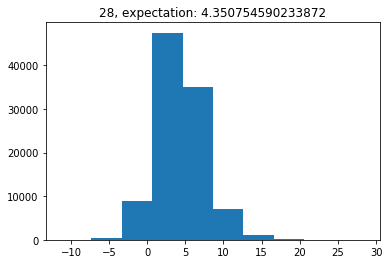

Train Supervised Observed Rating:  4.0


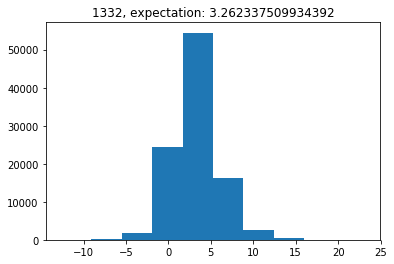

Train Supervised Observed Rating:  4.0


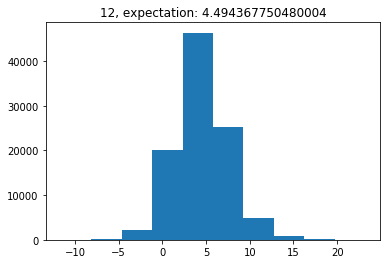

Plot a few test items
It actually generalizes quite well to test items due to early stopping
Test Supervised Observed Rating:  4.0


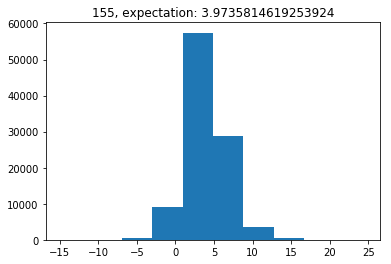

Test Supervised Observed Rating:  5.0


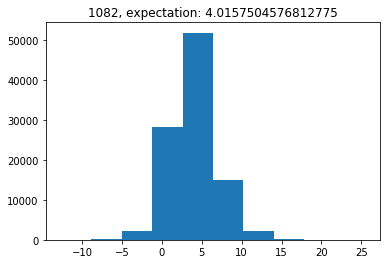

Test Supervised Observed Rating:  3.0


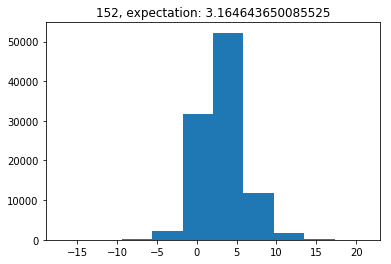

In [8]:
# Histogram Estimation
hspe = HistogramSamplingPosteriorEstimation(userLatents, itemLatents, userVariances, itemVariances)
numSamples = 100000
plotcount = 0

print("Number of users vs latentDim: ", userLatents.shape)
print("Number of items vs latentDim: ", itemLatents.shape)
print("UserVariances.shape", userVariances.shape)
print("itemVariances.shape", itemVariances.shape)

expectedValuesForUser = dict()
stdDevValuesForUser = dict()
sampledItemsForUser = dict()

#--------------------------------------------------
# Train on a single user for current demo
#--------------------------------------------------
numToPlot = 3 
# Pick a single user for demo
userIndex = 0
# for userIndex in range(numUsers): # Loop through over all users
if True: # Only run on one user # 
    # All the expected values for all items for current user (used for acquisition)
    expectedValuesForUser[userIndex] = np.zeros(itemLatents.shape[0])
    stdDevValuesForUser[userIndex] = np.zeros(itemLatents.shape[0])
    sampledItemsForUser[userIndex] = dict()
    # Train over all items
    for currRating in userDictTrain[userIndex]:
        itemIndex = currRating.movieId
        sampledItemsForUser[userIndex][itemIndex] = hspe.sampleForUserAndItem(userIndex, itemIndex, numSamples)
        # Calculate the expected value for acquisition Function
        expectedValuesForUser[userIndex][itemIndex] = hspe.expectation(sampledItemsForUser[userIndex][itemIndex])
        stdDevValuesForUser[userIndex][itemIndex] = hspe.stddev(sampledItemsForUser[userIndex][itemIndex])
    
    print("===============================")
    print("Plot a few observed items")
    print("===============================")
    count = 0
    for currRating in userDictTrain[userIndex]:
        count += 1
        itemIndex = currRating.movieId
        print("Train Supervised Observed Rating: ", currRating.rating)
        hspe.plotHist(sampledItemsForUser[userIndex][itemIndex], itemIndex)
        if count >= numToPlot:
            break
            
    print("===============================")
    print("Plot a few test items")
    print("It actually generalizes quite well to test items due to early stopping")
    print("===============================")
    count = 0
    for currRating in userDictTest[userIndex]:
        count += 1
        itemIndex = currRating.movieId
        print("Test Supervised Observed Rating: ", currRating.rating)
        hspe.plotHist(hspe.sampleForUserAndItem(userIndex, itemIndex, numSamples), itemIndex)
        if count >= numToPlot:
            break

# Chapter 4: Acquisition Function


In [22]:
# Acquisition Function
af = AcquisitionFunction()
eps = 0.33
if True: # only run on one user
    # Only print over the observes
    print("For user: ", userIndex)
    print("Mean is close to 0, which makes sense, since most items ratings are 0, mean=", np.mean(expectedValuesForUser[userIndex])) 
    print("Maximum expected value is <= 5, which is is good since ratings are less than 5. maxExpected=", np.max(expectedValuesForUser[userIndex]))
    print("Greedy would select item with the maximum expectation, item: ", af.greedy(expectedValuesForUser[userIndex]))
    print("randomChoice , item: ", af.randomlyPickOne(expectedValuesForUser[userIndex]))
    print("epsilonGreedy could return a random item with epsilon probability: " + str(eps) + ", item: " + str(af.epsilonGreedy(expectedValuesForUser[userIndex], eps)))
    print("epsilonGreedy could return a random item with epsilon probability: " + str(eps) + ", item: " + str(af.epsilonGreedy(expectedValuesForUser[userIndex], eps)))
    print("epsilonGreedy could return a random item with epsilon probability: " + str(eps) + ", item: " + str(af.epsilonGreedy(expectedValuesForUser[userIndex], eps)))
    print("epsilonGreedy could return a random item with epsilon probability: " + str(eps) + ", item: " + str(af.epsilonGreedy(expectedValuesForUser[userIndex], eps)))
    print("epsilonGreedy could return a random item with epsilon probability: " + str(eps) + ", item: " + str(af.epsilonGreedy(expectedValuesForUser[userIndex], eps)))
    print("thompsonSampling, item: ", af.thompsonSampling(sampledItemsForUser[userIndex], expectedValuesForUser[userIndex]))
    print("upperConfidenceBound, item: ", af.upperConfidenceBound(expectedValuesForUser[userIndex], stdDevValuesForUser[userIndex]))


For user:  6037
Mean is close to 0, which makes sense, since most items ratings are 0, mean= 0.006224156827831303
Maximum expected value is <= 5, which is is good since ratings are less than 5. maxExpected= 3.380612528907296
Greedy would select item with the maximum expectation, item:  185
randomChoice , item:  654
epsilonGreedy could return a random item with epsilon probability: 0.33, item: 185
epsilonGreedy could return a random item with epsilon probability: 0.33, item: 6
epsilonGreedy could return a random item with epsilon probability: 0.33, item: 185
epsilonGreedy could return a random item with epsilon probability: 0.33, item: 185
epsilonGreedy could return a random item with epsilon probability: 0.33, item: 654
thompsonSampling, item:  90
upperConfidenceBound, item:  185


# Chapter 5: Partitioning For Evaluation

In [11]:
# Partitions the user into 10 partitions
trainTestSplit = 0.1 # 10 percent training, 90 percent test
userDictTrain, userDictTest = mlp1m.getTrainTestUserTime(trainTestSplit)
numTestPartition = 10 # 10 test partition for each user
userDictTestPartition = mlp1m.partitionTestUserTime(userDictTest, numTestPartition)
print("done")

done


In [12]:
print("Ensure partition is correct and that each partition has appropriate number on 3 random users")
print("LastPartition also adds the remaining ratings and upper bounded by < 2*numRatingsPerPartition")
count = 0
for currUser in userDictTestPartition:
    count += 1
    print("currUserIndex: ", currUser)
    print("NumPartitionInCurrentUser: ", len(userDictTestPartition[currUser]))
    totalPartition = 0
    for i in range(numTestPartition):
        totalPartition += len(userDictTestPartition[currUser][i])
    print("TotalRatingsBeforePartition: ", len(userDictTest[currUser]))
    print("Total ratings in all partitions: ", totalPartition)
    print("NumRatingPerPartition: ", len(userDictTestPartition[currUser][0]))
    print("NumRatingInPerPartition + RemainingRating: ", len(userDictTestPartition[currUser][numTestPartition-1]))
    if count > 1:
        break
        

Ensure partition is correct and that each partition has appropriate number on 3 random users
LastPartition also adds the remaining ratings and upper bounded by < 2*numRatingsPerPartition
currUserIndex:  6039
NumPartitionInCurrentUser:  10
TotalRatingsBeforePartition:  307
Total ratings in all partitions:  307
NumRatingPerPartition:  30
NumRatingInPerPartition + RemainingRating:  37
currUserIndex:  6038
NumPartitionInCurrentUser:  10
TotalRatingsBeforePartition:  111
Total ratings in all partitions:  111
NumRatingPerPartition:  11
NumRatingInPerPartition + RemainingRating:  12


In [13]:
# Get the initial state
# Train once for the initial cold start model on all users
numEpoch = 5 # Training converges quickly
numHiddenDim = 10
userLatents, itemLatents, userVariances, itemVariances, varianceObsvNoise, userCovariances, itemCovariances, trainRMSE, testRMSE = trainVariationalBayes(userDictTrain, userDictTest, numItem, numEpoch, numHiddenDim)
print("Done Training")
resultFolder = "Result/"
dataName = "cold_ml1m"
saveFileName = resultFolder + dataName + "_numDim_"  + str(numHiddenDim) + "_numEpoch_" + str(numEpoch)
np.save(saveFileName + "_userLatents.npy", userLatents)
np.save(saveFileName + "_itemLatents.npy", itemLatents)
np.save(saveFileName + "_userVariances.npy", userVariances)
np.save(saveFileName + "_itemVariances.npy", itemVariances)
np.save(saveFileName + "_varianceObsvNoise.npy", np.array(varianceObsvNoise))
np.save(saveFileName + "_userCovariances.npy", userCovariances)
np.save(saveFileName + "_itemCovariances.npy", itemCovariances)
print("Done Saving")

Done Training
Done Saving


In [14]:
# Regret calculation
def getRegret(userDictTestPartition, userIndex, currTestPartition, selectedItem, tempDebug=""):
    '''
    Calculates the regret for current item
    '''
    maxRating = 0.0
    selectedRating = -1.0
    for currRating in userDictTestPartition[userIndex][currTestPartition]:
        maxRating = max(maxRating, currRating.rating)
        if currRating.movieId == selectedItem:
            selectedRating = currRating.rating
    if selectedRating < 0.0:
        # TODO: FIXME: There's a small bug in thompson sampling, 
        # It samples unobserved items from the user
        # This is cause you allow it to choose from all items for that user 
        # instead of only the current test partition item.
        print("Error, no such item, by method: ", tempDebug) 
        selectedRating = 0.0
    regret = maxRating - selectedRating
    return regret

# Chapter 6: Evaluation of Acquisition Function

In [15]:
numEpoch = 3 
# Posterior estimation
numSamples = 100000

# Acquisition Function
af = AcquisitionFunction()
eps = 0.33

# Loop through all users, evaluating each user independently from the initial state
# To store results
testRmseAllUser = np.zeros((numTestPartition))
regretActivation = dict() # Regret for each method
regretActivation["greedy"] = np.zeros((numTestPartition))
regretActivation["random"] = np.zeros((numTestPartition))
regretActivation["epsilonGreedy"] = np.zeros((numTestPartition))
regretActivation["upperConfidenceBound"] = np.zeros((numTestPartition))
regretActivation["thompsonSampling"] = np.zeros((numTestPartition))

limitNumUser = 3.0
count = 0.0
for userIndex in userDictTrain: 
    count += 1.0
    # Reload everything from scratch
    tempUserDictTrain = copy.deepcopy(userDictTrain)
    tempUserDictTest = copy.deepcopy(userDictTest)
    tempUserLatents = copy.deepcopy(userLatents)
    tempItemLatents = copy.deepcopy(itemLatents)
    tempUserVariances = copy.deepcopy(userVariances)
    tempItemVariances = copy.deepcopy(itemVariances)
    tempVarianceObsvNoise = copy.deepcopy(np.array(varianceObsvNoise))
    tempUserCovariances = copy.deepcopy(userCovariances)
    tempItemCovariances = copy.deepcopy(itemCovariances)
    sampledItemsForUser = dict()
    expectedValuesForUser = dict()
    stdDevValuesForUser = dict()
    # Histogram Estimation
    hspe = HistogramSamplingPosteriorEstimation(tempUserLatents, tempItemLatents, tempUserVariances, tempItemVariances)
    print("User Index:", userIndex)
    # All the expected values for all items for current user (used for acquisition)
    # Loop through each partition one at a time
    for currTestPartition in range(len(userDictTestPartition[userIndex])):
        # Sample from the current partition
        sampledItemsForUser[userIndex] = dict()
        expectedValuesForUser[userIndex] = np.zeros(itemLatents.shape[0])
        stdDevValuesForUser[userIndex] = np.zeros(itemLatents.shape[0])
        for currRating in userDictTestPartition[userIndex][currTestPartition]:
            itemIndex = currRating.movieId
            sampledItemsForUser[userIndex][itemIndex] = hspe.sampleForUserAndItem(userIndex, itemIndex, numSamples)
            # Calculate the expected value for acquisition Function
            expectedValuesForUser[userIndex][itemIndex] = hspe.expectation(sampledItemsForUser[userIndex][itemIndex])
            stdDevValuesForUser[userIndex][itemIndex] = hspe.stddev(sampledItemsForUser[userIndex][itemIndex])
            
            # All all from current partition for next training
            # Note: To only add selected item, 
            # will need to do separately for all the 5 different acquisition choices below
            # Add to next training partition
            tempUserDictTrain[userIndex].append(currRating)
            # Remove from next testing partition
            tempUserDictTest[userIndex].remove(currRating)
            
        # Pick an item according to different activation
        # Greedy
        itemChosen = af.greedy(expectedValuesForUser[userIndex])
        regret = getRegret(userDictTestPartition, userIndex, currTestPartition, itemChosen, "greedy")
        regretActivation["greedy"][currTestPartition] += regret
        # random
        itemChosen = af.randomlyPickOne(expectedValuesForUser[userIndex])
        regret = getRegret(userDictTestPartition, userIndex, currTestPartition, itemChosen, "random")
        regretActivation["random"][currTestPartition] += regret
        # eGreedy
        itemChosen = af.epsilonGreedy(expectedValuesForUser[userIndex], eps)
        regret = getRegret(userDictTestPartition, userIndex, currTestPartition, itemChosen, "eGreedy")
        regretActivation["epsilonGreedy"][currTestPartition] += regret
        # ucb
        itemChosen = af.upperConfidenceBound(expectedValuesForUser[userIndex], stdDevValuesForUser[userIndex])
        regret = getRegret(userDictTestPartition, userIndex, currTestPartition, itemChosen, "upperConfidenceBound")
        regretActivation["upperConfidenceBound"][currTestPartition] += regret
        # thompson Sampling
        itemChosen = af.thompsonSampling(sampledItemsForUser[userIndex], expectedValuesForUser[userIndex])
        regret = getRegret(userDictTestPartition, userIndex, currTestPartition, itemChosen, "thompsonSampling")
        regretActivation["thompsonSampling"][currTestPartition] += regret
        tempUserLatents, tempItemLatents, tempUserVariances, tempItemVariances, tempVarianceObsvNoise, tempUserCovariances, tempItemCovariances, tempTrainRMSE, tempTestRMSE = trainVariationalBayes(tempUserDictTrain, tempUserDictTest, numItem, numEpoch, numHiddenDim)
        
        # Cumulative RMSE over all users for each partition
        testRmseAllUser[currTestPartition] += tempTestRMSE[-1]
    if count >= limitNumUser:
        break
    

User Index: 6039
User Index: 6038
User Index: 6037
Error, no such item, by method:  thompsonSampling
Error, no such item, by method:  thompsonSampling


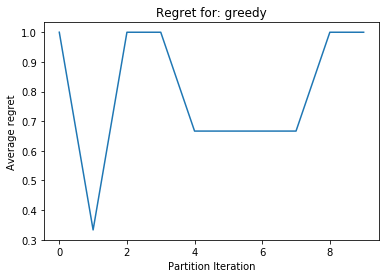

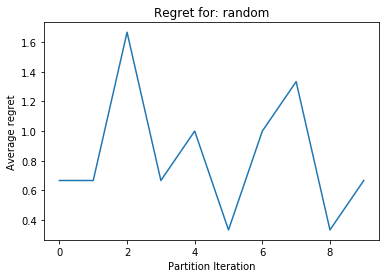

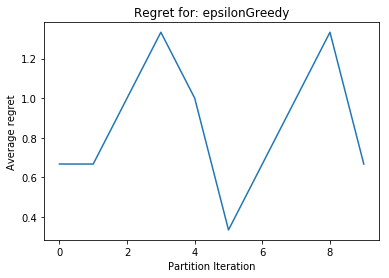

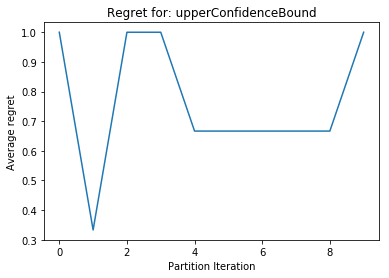

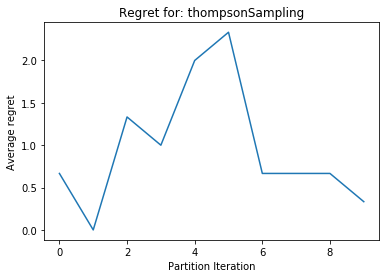

In [17]:
# Start plotting 
plotIndex = 10
for currKey in regretActivation:
    x = np.array([i for i in range(len(regretActivation[currKey]))])
    y = regretActivation[currKey]/float(limitNumUser)
    plt.figure(plotIndex)
    plotIndex += 1
    plt.title("Regret for: " + str(currKey))
    plt.xlabel("Partition Iteration")
    plt.ylabel("Average regret")
    plt.plot(x, y)
    plt.show()

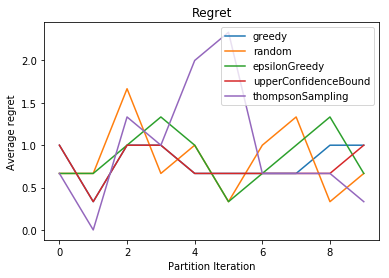

It appears Thompson Sampling does perform the best


In [24]:
# plot everything in 1 figure
plotIndex += 1
plt.figure(plotIndex)
plotIndex += 1
plt.title("Regret")
plt.xlabel("Partition Iteration")
plt.ylabel("Average regret")
for currKey in regretActivation:
    x = np.array([i for i in range(len(regretActivation[currKey]))])
    y = regretActivation[currKey]/float(limitNumUser)
    plt.plot(x, y, label=str(currKey))
plt.legend()
plt.show()

print("It appears Thompson Sampling does perform the best")

# Chapter 7: Evaluation of Model Adaptability

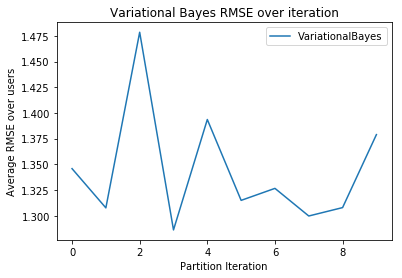

It appears the model is indeed training


In [23]:
x = np.array([i for i in range(len(testRmseAllUser))])
y = testRmseAllUser/float(limitNumUser)
plt.figure(plotIndex)
plotIndex += 1
plt.title("Variational Bayes RMSE over iteration")
plt.xlabel("Partition Iteration")
plt.ylabel("Average RMSE over users")
plt.plot(x, y, label="VariationalBayes")
plt.legend()
plt.show()

print("It appears the model is indeed training")